# Tutorial for infer_structcol package

This tutorial explains how to use the infer_structcol package to infer the volume fraction, particle radius, and thickness of a structurally colored sample using experimental reflectance and transmittance data. 

In [1]:
# standard imports
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os
import time
import seaborn as sns

# import package
import infer_structcol as ifs

## Set parameters

In [2]:
nwalkers = 14                                   # number of walkers to step through different parameters
nsteps = 10                                     # number of steps for each walker to take
particle_index = 1.59                           # refractive index of colloidal particles 
matrix_index = 1                                # refractive index of matrix material surrounding particles
wavelengths = [450,500,550,600,650,700,750,800] # wavelengths of interest where spectrum should be calculated (in nm)
directory = os.path.join(os.getcwd(),
                         'infer_structcol',
                         'tests','test_data',
                         'experimental_data')   # path where the data is found
refl_reference_file = 'R_ref.txt'               # name of reference file for reflectance data
refl_dark_file = 'R_dark.txt'                   # name of dark file for reflectance data
trans_reference_file = 'T_ref.txt'              # name of reference file for transmittance data
trans_dark_file = 'T_dark.txt'                  # name of dark file for transmittance data

# User's best guess for the parameters to be inferred: theta_guess should be a dictionary 
# with volume fraction phi, particle radius, and thickness. Radius should be in nm, thickness should be in um
theta_guess = {'phi':0.5, 'radius':119, 'thickness':100} 

# Range of values that contain the parameters according to the user's knowledge of the system. 
# theta_range should be a dictionary with the min and max values of the volume fraction, radius, and thickness
theta_range = {'min_phi':0.35, 'max_phi':0.6, 'min_radius':80, 'max_radius': 150, 
               'min_thickness':70, 'max_thickness':300} 

## Infer parameters

### Convert raw data into a readable format
The user is expected to prepare reflectance and/or transmittance data in the following format:  

3 tab-separated columns:  wavelength | normalized reflectance or transmittance (from 0 to 1)| standard deviation 

In this package, we provide code that converts raw unprocessed data from some commonly used instruments into the required format. Currently, the instruments for which format conversion is available are:

1) Ocean Optics HR2000+ Spectrometer, Ocean Optics SpectraSuite software  
2) Agilent Technologies Cary 7000 UMS 

###### Instructions for raw data in the format of instrument 1):
All data files for transmission (including reference and dark measurements) should be located in a directory called 'transmission', and all data files for reflection should be located in a directory called 'reflection'. They should be .txt files with two $\textit{tab-separated}$ columns, where the first is the wavelength and the second is the reflectance or transmittance fraction. Any header information at the top or bottom of the file will be ignored. The reference and dark spectra should have unique names as specified by the user, and the transmission or reflection spectra can have any unspecified name. The code will assume that any file in the data directory other than the reference or dark files is a transmittance or reflectance spectrum. It is expected that the user will include several reflectance/transmittance measurements of the same sample in order to calculate an uncertainty on the data. 

The data must first be converted into a normalized spectrum with values from 0 to 1, using the reference and dark spectra. The dark spectrum is meant to represent the dark signal of the detection apparatus. It should be recorded with no illumination source and no sample in place. The reference spectrum is meant to represent an unobstructed light source. In the case of transmission, it should be recorded with the same illumination source as actual measurements, but without a sample in place. In the case of reflection, it should be recorded with an ideal reflector in the place of the sample. Normalization is accomplished using the convert_data() function. The converted data consists of a file for each experiment with 3 columns: wavelength, normalized intensity, and uncertainty. The uncertainty at each wavelength is the sample standard deviation calculated from all of the reflectance/transmittance data in the directory.

###### Instructions for raw data in the format of instrument 2):
The raw data is a .csv file with columns separated by commas. The columns correspond to different sample measurements. The wavelengths are assumed to be from 800 to 400 in decreasing order, in increments of 1. The sample names in each column must contain the word "sample". 

### Create a normalized spectrum from the formatted data and load it
A spectrum from the converted data must then be loaded using the load_spectrum() function. The user will choose one spectrum out of the data and pass its full filepath as a parameter of load_spectrum. The user can choose to load a spectrum with a reflectance, transmittance, or both, by using the appropriate keyword arguments. 

In [3]:
# Using raw data in format of instrument 1) 
# create a converted data file for transmittance and reflectance spectra in the directory
ifs.convert_data(wavelengths, refl_reference_file, refl_dark_file, os.path.join(directory, 'reflection'))
ifs.convert_data(wavelengths, trans_reference_file, trans_dark_file, os.path.join(directory, 'transmission'))


# load the converted data file as a Spectrum object
spect = ifs.load_spectrum(refl_filepath = os.path.join(directory, 'reflection', 'converted', '0_data_file.txt'), 
                          trans_filepath = os.path.join(directory, 'transmission', 'converted', '0_data_file.txt'))

##### Define sample object
This object contains the parameters relevant to the colloidal glass sample.

In [4]:
samp = ifs.Sample(spect.wavelength, particle_index, matrix_index)

##### Calculate the uncertainties of the multiple scattering calculations
The user can choose the number of trajectories and scattering events for the multiple scattering calculations such that the resulting uncertainties are smaller than those of the experimental data. If the user does not specify the number of trajectories and events, the code will assume default values of 600 trajectories and 200 scattering events. 

The calculation of the uncertainties (taken to be 1 standard deviation) can be done as follows:

Reflectance standard deviations: [ 0.01597244  0.01735117  0.01663265  0.01973295  0.02393515  0.02471046
  0.02288042  0.02042153]
Transmittance standard deviations: [ 0.01597244  0.01735117  0.01663265  0.01973295  0.02393515  0.02471046
  0.02288042  0.02042153]


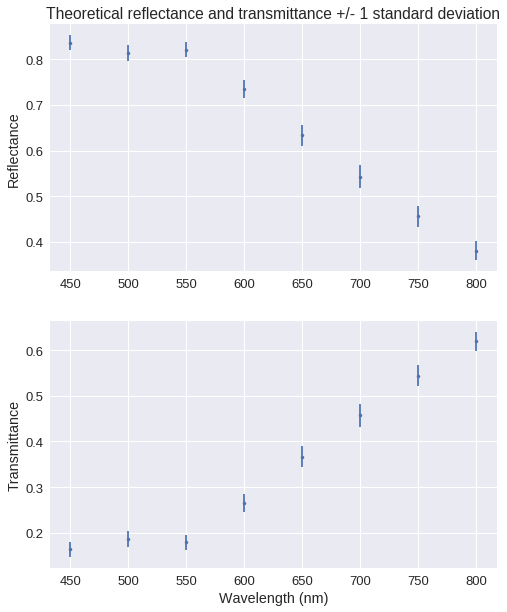

In [9]:
# Calculate the standard deviation of the multiple scattering calculations based on number of trajectories and events
ntrajectories = 500
nevents = 200
nruns = 100   # number of multiple scattering calculations for computing the standard deviation
sigma = ifs.calc_sigma(theta_guess['phi'], theta_guess['radius'], theta_guess['thickness'], samp, 
                       ntrajectories, nevents, nruns, plot=True)
print('Reflectance standard deviations: ' + str(sigma[0]))
print('Transmittance standard deviations: ' + str(sigma[1]))

##### Perform inference calculation

Here, we pass in our best guesses for parameter estimates as `theta_guess` and the ranges as `theta_range`. If you don't have a guess or a range, you can call `ifs.run_mcmc` without the `theta_guess` and/or the `theta_range` argument and it will use default values for the calculation of the maximum likelihood parameters, which are used as starting points for the inference calculation.

In [8]:
# time the calculation, if desired
t0 = time.time()

# run the markov chain monte carlo calculation to step through different values of 
# parameters and infer the most likely values
walkers = ifs.run_mcmc(spect, samp, nwalkers, nsteps, theta_guess=theta_guess, theta_range=theta_range, 
                       ntrajectories=ntrajectories, nevents=nevents, seed=None)

# print the time the calculation took
print(time.time()-t0)

99.77768516540527


##### Plot the traces
Plot the values for the loss parameters and the volume fraction at each step of the Markov chain.

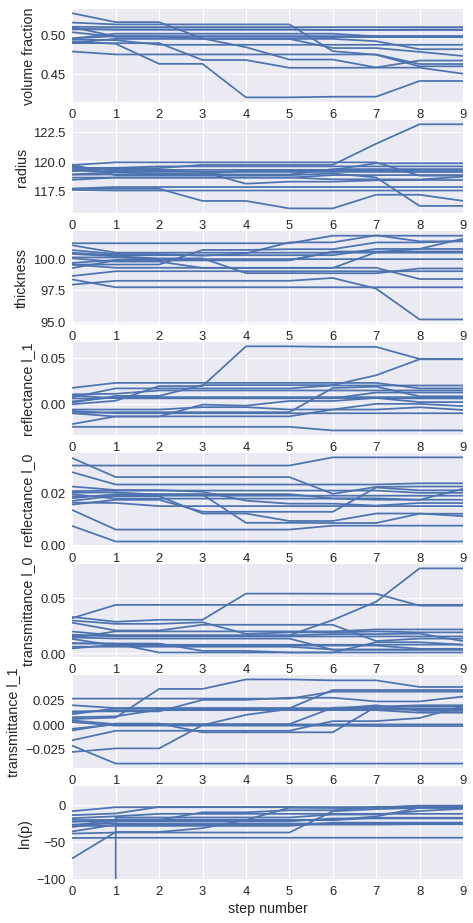

In [11]:
vf = walkers.chain[:,:,0]
radius = walkers.chain[:,:,1]
thickness = walkers.chain[:,:,2]
refl_l0 = walkers.chain[:,:,3]
refl_l1 = walkers.chain[:,:,4]
trans_l0 = walkers.chain[:,:,5]
trans_l1 = walkers.chain[:,:,6]

fig, (ax_vf, ax_radius, ax_thickness, 
      ax_refl_l1, ax_refl_l0, ax_trans_l0, ax_trans_l1, ax_lnprob) = plt.subplots(8, figsize=(7,16))
ax_vf.set(ylabel='volume fraction')
ax_radius.set(ylabel='radius')
ax_thickness.set(ylabel='thickness')
ax_refl_l0.set(ylabel='reflectance l_0')
ax_refl_l1.set(ylabel='reflectance l_1')
ax_trans_l0.set(ylabel='transmittance l_0')
ax_trans_l1.set(ylabel='transmittance l_1')
ax_lnprob.set(ylabel='ln(p)')
ax_lnprob.set(xlabel='step number')
ax_lnprob.set(ylim=[-100,25])
for i in range(nwalkers):
    sns.tsplot(vf[i,:], ax=ax_vf)
    sns.tsplot(radius[i,:], ax=ax_radius)
    sns.tsplot(thickness[i,:], ax=ax_thickness)
    sns.tsplot(refl_l0[i,:], ax=ax_refl_l0)
    sns.tsplot(refl_l1[i,:], ax=ax_refl_l1)
    sns.tsplot(trans_l0[i,:], ax=ax_trans_l0)
    sns.tsplot(trans_l1[i,:], ax=ax_trans_l1)
    sns.tsplot(walkers.lnprobability[i,:], ax=ax_lnprob)

##### Estimate the most likely volume fraction, particle radius, and sample thickness

The most likely volume fraction is found by calculating the median value of the volume fraction traces after cutting off the burn-in time before the walkers have equilbrated to a steady state. We calculate a 68% confidence interval using the built-in numpy percentile function. The same procedure is applied to the particle radius and sample thickness. 

In [12]:
# trim off the burn in time, which we observe from the plots above. The plots do not appear to have burned in for the 
# 10 steps used in this tutorial, but let's set the burn in index to 5 to illustrate how to find the inferred volume 
# fraction.
trim_index = 5
vf_trimmed = np.ndarray.flatten(vf[:,trim_index:])
radius_trimmed = np.ndarray.flatten(radius[:,trim_index:])
thickness_trimmed = np.ndarray.flatten(thickness[:,trim_index:])

# find the median of the volume fractions of the walkers
vf_inferred = np.median(vf_trimmed)
radius_inferred = np.median(radius_trimmed)
thickness_inferred = np.median(thickness_trimmed)

print("The inferred volume fraction is {:.3f} + {:.3f} - {:.3f}".format(vf_inferred,
                                                                       np.percentile(vf_trimmed,84)-vf_inferred,
                                                                       vf_inferred - np.percentile(vf_trimmed,16)))
print("The inferred particle radius is {:.3f} + {:.3f} - {:.3f}".format(radius_inferred,
                                                                       np.percentile(radius_trimmed,84)-radius_inferred,
                                                                       radius_inferred - np.percentile(radius_trimmed,16)))
print("The inferred thickness is {:.3f} + {:.3f} - {:.3f}".format(thickness_inferred,
                                                                       np.percentile(thickness_trimmed,84)-thickness_inferred,
                                                                       thickness_inferred - np.percentile(thickness_trimmed,16)))

The inferred volume fraction is 0.489 + 0.017 - 0.029
The inferred particle radius is 118.843 + 0.735 - 1.297
The inferred thickness is 100.269 + 1.007 - 1.785


##### Analyzing real data

Actual analysis requires many more trajectories taking many more steps. The numbers used here were selected to demonstrate the analysis steps with code that runs relatively quickly. Typical data analysis runs use hundreds of walkers each taking thousands of steps (with a few hundred steps required to burn in). 